# Data Generation for Book Viz

This notebook downloads raw book text for 11 books from [Project Gutenberg](http://www.gutenberg.org/) and optionally saves: 1) saves a single JSON file with sentences, chapter breaks, and other metadata for all books (`book_text_data.json`), 2) saves a zip file containing a JSON for each book, where entries correspond to sections at different levels of granularity (`section_text_data.zip`), and 3) saves zip files containing reduced-dimensionality embeddings for each book via TSNE, UMAP, and PCA in byte format (`tsne_bytes.zip`, `umap_bytes.zip`, and `pca_bytes.zip`).  

You need 1) for all visualizations, 2) for any of the section-level visualizations, and 3) for the sentence-level visualizations -- check the boxes below accordingly.

After running all cells, you should see the downloaded files. Move book_text_data.json to the `data` folder of the repo. Unzip the zip files and for each, move the directory within the `content` directory to the `data` folder of the repo.  

In [1]:
#@title Files to Save
save_book_metadata = True #@param {type:"boolean"}
save_cluster_data = True #@param {type:"boolean"}
save_byte_data = True #@param {type:"boolean"}

## Imports

In [156]:
!pip install colabtools

You should consider upgrading via the '/Users/harinisuresh/.virtualenvs/book-viz/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install umap-learn

     |████████████████████████████████| 80 kB 3.5 MB/s eta 0:00:011
  Using cached numpy-1.20.1-cp37-cp37m-macosx_10_9_x86_64.whl (16.0 MB)
  Using cached scikit_learn-0.24.1-cp37-cp37m-macosx_10_13_x86_64.whl (7.2 MB)
     |████████████████████████████████| 30.7 MB 19.2 MB/s eta 0:00:01��████████████▊| 30.5 MB 19.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 25.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 20.8 MB/s eta 0:00:01
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
     |████████████████████████████████| 303 kB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 18.5 MB 7.4 MB/s eta 0:00:011
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=24496b67abd74a0dba22c2bb31ba3c4feb31c20b62dfe3935195b12253b19481
  Stored in directory: /Users/harinisuresh/Library/Caches/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=

In [6]:
!pip install MulticoreTSNE

  Using cached MulticoreTSNE-0.1.tar.gz (20 kB)
  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp37-cp37m-macosx_10_15_x86_64.whl size=36431 sha256=f3e64ff0c94c66530b6d6639e695f89694eebf79b71a0b222075f59d047a75dd
  Stored in directory: /Users/harinisuresh/Library/Caches/pip/wheels/80/47/df/c0d66e9f775f33281c422a1964de86a59c47f93bb8c37643e3
Successfully built MulticoreTSNE
You should consider upgrading via the '/Users/harinisuresh/.virtualenvs/book-viz/bin/python -m pip install --upgrade pip' command.


In [157]:
import os
import re
import json
import umap
from scipy import stats
import numpy as np
import pandas as pd
import colabtools

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as MCTSNE

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

## Loading, Preprocessing + Embedding Functions

In [76]:
end_strings = ["end of project gutenberg", "end of the project gutenberg", "transcriber's notes"]

def read_data(filename, prefix_lines=0):
    book_string = ""
    with open(filename, "r") as f:
        for i in range(prefix_lines):
            next(f)
        
        line = f.readline()
        while line:
            if end_strings[0] in line.lower() or end_strings[1] in line.lower() or end_strings[2] in line.lower(): 
                return book_string
            book_string += line
            line = f.readline()
        
    return book_string

In [39]:
book_roman_num_pattern = '^(BOOK\s)(M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3}))(\.)?$'
roman_num_pattern = '^(M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3}))\.$'
number_pattern = '^\d*\.$'
written_num_pattern = '^((FIRST)|(SECOND)|(THIRD)|(FOURTH))\sACT'

def match_chapter_name(line):
  first_word = line.split()[0]
  first_two_words = ' '.join(line.split()[0:2])

  # match text == chapter
  if first_word.lower() == 'chapter': 
    return 0

  # match digit plus period (e.g., "12.")
  elif bool(re.search(number_pattern, first_word)):
    return 1
  
  # match roman numeral plus period (e.g., "II.")
  elif bool(re.search(roman_num_pattern, first_word)):
    return 2

  # match roman numeral plus optional period with preceding "BOOK" (e.g., "BOOK II.")
  elif bool(re.search(book_roman_num_pattern, first_two_words)):
    return 3

  # match written number + "ACT" (e.g., "SECOND ACT")
  elif bool(re.search(written_num_pattern, first_two_words)):
    return 4

  return -1

def replace_spaces_and_newlines(par_string):
  par_string = par_string.replace("\n", " ")
  par_string = " ".join(par_string.split())
  return par_string

def split_text(book_string, split_type):
  if split_type == 'paragraph':
    chunks = book_string.split('\n\n')
  elif split_type == 'sentence':
    chunks = split_into_sentences(book_string)
  chunks_without_empty_strings = list(filter(None, chunks))
  chunks_without_single_newlines = list(map(replace_spaces_and_newlines, chunks_without_empty_strings))
  return chunks_without_single_newlines

def get_chapter_breaks(book_text_list):
  chapter_breaks = []
  chapter_break_types = [] 
  for i,s in enumerate(book_text_list):
    try: 
      if match_chapter_name(s) >= 0:
        chapter_breaks.append(i)
        chapter_break_types.append(match_chapter_name(s))
    except: 
      pass
  
  if len(chapter_breaks) == 0: 
    return [0]

  chapter_breaks = np.array(chapter_breaks)
  chapter_break_types = np.array(chapter_break_types)
  majority_type = stats.mode(chapter_break_types).mode[0]
  chapter_breaks = chapter_breaks[np.where(chapter_break_types == majority_type)]
  return [0] + chapter_breaks.tolist()

def get_paragraph_breaks(book_text_list):
  par_idx = [1  if '<startpar>' in sentence else 0 for sentence in book_text_list]
  return par_idx

def remove_par_markers(book_text_list):
  clean_sentences = [sentence.replace("<startpar>","") for sentence in book_text_list]
  clean_sentences = [s.strip() for s in clean_sentences]
  return clean_sentences

In [40]:
# -*- coding: utf-8 -*-
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|me|edu)"
digits = "([0-9])"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n\n", "<stop><startpar>")
    text = text.replace("\n"," ")
    text = re.sub("\[Illustration.{0,50}\]", " ", text)
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    if ". . ." in text: text = text.replace(". . .","<prd><prd><prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text) 

    text = re.sub("\?(\"|“|”|')(\s[a-z])", "<q>\\1\\2", text)
    text = re.sub("\!(\"|“|”|')(\s[a-z])", "<ex>\\1\\2", text)
    text = re.sub("\.(\"|“|”|')(\s[a-z])", "<prd>\\1\\2", text)

    text = re.sub("\?('|’|’)?(\"|“|”)", "<q>\\1\\2<stop>", text)
    text = re.sub("\!('|’|’)?(\"|“|”)", "<ex>\\1\\2<stop>", text)
    text = re.sub("\.('|’|’)?(\"|“|”)", "<prd>\\1\\2<stop>", text)

    text = re.sub("\?('|’|’)", "<q>\\1<stop>", text)
    text = re.sub("\!('|’|’)", "<ex>\\1<stop>", text)
    text = re.sub("\.('|’|’)", "<prd>\\1<stop>", text)

    text = re.sub("\?(\]|\))", "<q>\\1<stop>", text)
    text = re.sub("\!(\]|\))", "<ex>\\1<stop>", text)
    text = re.sub("\.(\]|\))", "<prd>\\1<stop>", text)

    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    text = text.replace("<q>","?")
    text = text.replace("<ex>","!")
    text = text.replace("<com>",",")
    text = text.replace("<apos>","'")
    sentences = text.split("<stop>")
    sentences = [s.strip() for s in sentences]
    sentences = list(filter(None, sentences)) 
    sentences = [x for x in sentences if x != "<startpar>" and x != ""]
    # sentences = sentences[:-1]
    return sentences

In [41]:
def get_embeddings(embed_func, sentences):
  batch_size = 1000
  output_shape = (len(sentences), output_dim)
  sentence_features = np.full(output_shape, 0.0)
  for batch_idx in np.arange(0, len(sentences), batch_size):
    end_idx = min(batch_idx + batch_size, len(sentences))
    batch = sentences[batch_idx:end_idx]
    output = embed_func(batch)
    sentence_features[batch_idx:end_idx, :] = output

  return sentence_features

In [42]:
def reduce_embeddings(emb, alg, normalize=True):
  if alg == 'tsne': 
    reduced = MCTSNE(n_jobs=4, n_components=3).fit_transform(emb)

  elif alg == 'pca':
    reduced = PCA(n_components=3).fit_transform(emb)  

  elif alg == 'ica':
    reduced = FastICA(n_components=3).fit_transform(emb)

  elif alg == 'umap':
    reduced = umap.UMAP(n_components=3, n_neighbors=20).fit_transform(emb)

  if normalize: 
    reduced = normalize_columns(reduced)

  return np.around(reduced, 3)

In [43]:
def vec_cosine_similarity(a, b):
  dot_prod = np.dot(a, b)
  norm_a = np.linalg.norm(a, 2)
  norm_b = np.linalg.norm(b, 2)
  return dot_prod / (norm_a * norm_b)

def get_embedding_diffs(emb, window_size):
  diff_vec = [0]
  for i in range(1, emb.shape[0]):
    vec1 = emb[max(i - window_size, 0) : i].mean(axis=0)
    vec2 = emb[i : min(i + window_size, emb.shape[0])].mean(axis=0)
    cosine_sim = vec_cosine_similarity(vec1, vec2)
    diff_vec.append(cosine_sim)
  return diff_vec

def normalize_columns(arr):
  return np.apply_along_axis(lambda x: (x - x.min())/(x.max() - x.min()), 0, arr) 

def reduce_embeddings_with_diff(emb, window_size):
  diffs = 1 - normalize_columns(np.array(get_embedding_diffs(emb, window_size)))
  return np.expand_dims(diffs, 1)

def get_embedding_moving_avg(emb, window_size, chapter_breaks=[]): 
  if window_size == 0: return emb
  if len(chapter_breaks) == 0: return moving_avg_helper(emb, window_size)
  
  chapter_breaks = chapter_breaks.append(len(emb))
  moving_avg_emb = np.zeros(emb.shape)
  for i in range(len(chapter_breaks) - 1):
    chapter_emb = emb[chapter_breaks[i]:chapter_breaks[i+1]]
    moving_avg_emb[chapter_breaks[i]:chapter_breaks[i+1]] = moving_avg_helper(chapter_emb, window_size)
  
  return moving_avg_emb

def moving_avg_helper(emb, window_size):
  moving_avg_emb = []
  for i in range(0, emb.shape[0]):
    window = emb[max(i - window_size, 0) : min(i + window_size + 1, emb.shape[0])]
    moving_avg = np.sum(window, axis=0) / window.shape[0]
    moving_avg_emb.append(moving_avg)
  moving_avg_emb = np.array(moving_avg_emb)
  return moving_avg_emb

def get_windowed_sentences(sentences, window_size, chapter_breaks=[]): 
  if window_size == 0: return sentences
  
  chapter_breaks.append(len(sentences))

  windowed_sentences = []
  
  for i in range(len(chapter_breaks) - 1):
    chapter_sentences = sentences[chapter_breaks[i]:chapter_breaks[i+1]]
    new_chapter_sentences = []
    for j in range(len(chapter_sentences)):
      window = chapter_sentences[max(j - window_size, 0) : min(j + window_size + 1, len(chapter_sentences))]
      new_chapter_sentences.append(' '.join(window))
    windowed_sentences.append(new_chapter_sentences)

  flattened = [item for sublist in windowed_sentences for item in sublist]
  return flattened

## quantile min max normalization 
def quantile_normalize_helper(col):
  max = np.quantile(col, 0.975)
  min = np.quantile(col, 0.025)
  norm = (col - min) / (max - min)
  return np.clip(norm, 0, 1) 

def quantile_normalize_columns(arr):
  return np.apply_along_axis(quantile_normalize_helper, 0, arr) 


## Read + Save Book Data

### Upload book files

In [11]:
BOOK_FNAMES = ['alice-in-wonderland.txt',
               'emma.txt',  
               'peter-pan.txt',
               'siddhartha.txt',
               'moby-dick.txt',
               'pride-and-prejudice.txt',
               'wizard-of-oz.txt',
               'great-expectations.txt',
               'metamorphosis.txt',
               'scarlet-letter.txt',
               'jane-eyre.txt']

In [12]:
!mkdir raw_book_text

In [20]:
# download files
!wget -O raw_book_text/alice-in-wonderland.txt https://www.gutenberg.org/files/11/11-0.txt
!wget -O raw_book_text/emma.txt https://www.gutenberg.org/files/158/158-0.txt
!wget -O raw_book_text/wizard-of-oz.txt https://www.gutenberg.org/files/55/55.txt
!wget -O raw_book_text/siddhartha.txt http://www.gutenberg.org/cache/epub/2500/pg2500.txt
!wget -O raw_book_text/scarlet-letter.txt https://www.gutenberg.org/files/25344/25344-0.txt
!wget -O raw_book_text/pride-and-prejudice.txt https://www.gutenberg.org/files/1342/1342-0.txt
!wget -O raw_book_text/peter-pan.txt https://www.gutenberg.org/files/16/16-0.txt
!wget -O raw_book_text/moby-dick.txt http://www.gutenberg.org/files/2701/2701-0.txt
!wget -O raw_book_text/great-expectations.txt http://www.gutenberg.org/files/1400/1400-0.txt
!wget -O raw_book_text/metamorphosis.txt http://www.gutenberg.org/cache/epub/5200/pg5200.txt 
!wget -O raw_book_text/jane-eyre.txt http://www.gutenberg.org/files/1260/1260-0.txt

--2021-03-10 10:10:49--  https://www.gutenberg.org/files/11/11-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174693 (171K) [text/plain]
Saving to: ‘raw_book_text/alice-in-wonderland.txt’

raw_book_text/alice 100%[===================>] 170.60K   989KB/s    in 0.2s    

2021-03-10 10:10:50 (989 KB/s) - ‘raw_book_text/alice-in-wonderland.txt’ saved [174693/174693]

--2021-03-10 10:10:50--  https://www.gutenberg.org/files/158/158-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 927445 (906K) [text/plain]
Saving to: ‘raw_book_text/emma.txt’

raw_book_text/emma. 100%[===================>] 905.71K  2.12MB/s    in 0.4s    

2021-03-10 10:10:50 (2.12 MB/s) - ‘raw_book_text/

### Process + save as JSON

In [137]:
BOOK_IDX = dict(zip(BOOK_FNAMES, range(len(BOOK_FNAMES))))

In [138]:
prefix_lines = dict.fromkeys(BOOK_FNAMES)
prefix_lines['emma.txt'] = 42
prefix_lines['alice-in-wonderland.txt'] = 55
prefix_lines['wizard-of-oz.txt'] = 102
prefix_lines['siddhartha.txt'] = 41
prefix_lines['scarlet-letter.txt'] = 1617
prefix_lines['pride-and-prejudice.txt'] = 164
prefix_lines['peter-pan.txt'] = 65
prefix_lines['moby-dick.txt'] = 844
prefix_lines['great-expectations.txt'] = 106
prefix_lines['metamorphosis.txt'] = 43
prefix_lines['jane-eyre.txt'] = 174

In [139]:
book_texts = []

for book in BOOK_FNAMES:
  print(book)
  book_texts.append(read_data("raw_book_text/" + book, prefix_lines[book]))

alice-in-wonderland.txt
emma.txt
peter-pan.txt
siddhartha.txt
moby-dick.txt
pride-and-prejudice.txt
wizard-of-oz.txt
great-expectations.txt
metamorphosis.txt
scarlet-letter.txt
jane-eyre.txt


In [140]:
book_sentences = list(map(lambda x: split_text(x, 'sentence'), book_texts))
par_breaks = list(map(get_paragraph_breaks, book_sentences))
book_sentences =  list(map(remove_par_markers, book_sentences))
chapter_breaks_sentences = list(map(get_chapter_breaks, book_sentences))

In [141]:
book_paragraphs = list(map(lambda x: split_text(x, 'paragraph'), book_texts))
chapter_breaks_paragraphs = list(map(get_chapter_breaks, book_paragraphs))

In [142]:
book_text_data = []
for book in BOOK_FNAMES:
  book_text_data.append({
      'name': book,
      'sentences': book_sentences[BOOK_IDX[book]],
      'paragraphs': book_paragraphs[BOOK_IDX[book]],
      'chapter_breaks_by_sentence': chapter_breaks_sentences[BOOK_IDX[book]],
      'chapter_breaks_by_paragraph': chapter_breaks_paragraphs[BOOK_IDX[book]],
      'paragraph_breaks': par_breaks[BOOK_IDX[book]]
  })

In [143]:
with open('book_text_data.json', 'w') as f:
  json.dump(book_text_data, f)

## Embedding

In [144]:
#@title Hub module string
hub_module = "https://tfhub.dev/google/universal-sentence-encoder/4" # @param ["https://tfhub.dev/google/universal-sentence-encoder/4"]

output_dim_dict = {
    "https://tfhub.dev/google/universal-sentence-encoder/4": 512
}

output_dim = output_dim_dict[hub_module]
embed_func = hub.load(hub_module)

In [145]:
if not os.path.exists('umap_bytes'):
  !mkdir umap_bytes
if not os.path.exists('tsne_bytes'):
  !mkdir tsne_bytes
if not os.path.exists('pca_bytes'):
  !mkdir pca_bytes

### Reduce embedding dimensionality

In [146]:
split_by = 'sentences'
prefix = 'universal'

if save_byte_data:
  windows = range(5)
  reduce_algs = ['umap', 'tsne', 'pca']
else: 
  windows = [1]
  reduce_algs = ['umap']

for i in range(0, len(book_text_data)):
  print("reducing book", i)
  for reduce_alg in reduce_algs:
    print("with:", reduce_alg)
    for window in windows:
      print("and moving window size:", window)
      save_folder = reduce_alg + '_bytes'
      sentences = get_windowed_sentences(book_text_data[i][split_by], window, book_text_data[i]['chapter_breaks_by_' + split_by[:-1]])
      emb = get_embeddings(embed_func, sentences)
      reduced = reduce_embeddings(emb, reduce_alg)
      normalized = quantile_normalize_columns(reduced)
      arr_bytes = normalized.astype('float32').tobytes()

      fname = '-'.join([str(i), prefix, reduce_alg, str(window)])
      
      with open(os.path.join(save_folder, fname), 'wb') as f:
        f.write(arr_bytes)

reducing book 0
with: umap
and moving window size: 0
and moving window size: 1
and moving window size: 2
and moving window size: 3
and moving window size: 4
with: tsne
and moving window size: 0
and moving window size: 1
and moving window size: 2
and moving window size: 3
and moving window size: 4
with: pca
and moving window size: 0
and moving window size: 1
and moving window size: 2
and moving window size: 3
and moving window size: 4
reducing book 1
with: umap
and moving window size: 0
and moving window size: 1
and moving window size: 2
and moving window size: 3
and moving window size: 4
with: tsne
and moving window size: 0
and moving window size: 1
and moving window size: 2
and moving window size: 3
and moving window size: 4
with: pca
and moving window size: 0
and moving window size: 1
and moving window size: 2
and moving window size: 3
and moving window size: 4
reducing book 2
with: umap
and moving window size: 0
and moving window size: 1
and moving window size: 2
and moving window s

## Sectioning

In [147]:
def get_cutoffs(emb, size_goals=[200,100,50]): 
  cutoff_sizes = []
  all_cutoffs = np.arange(0,1.2,0.05)
  for cutoff in all_cutoffs:
    distances = [0] + [np.linalg.norm(emb[i] - emb[i-1]) for i in range(1, len(emb))]
    distances = np.array(distances)
    size = len(np.where(distances > cutoff)[0])
    cutoff_sizes.append(size)

  chosen_cutoffs = []
  cur_goal = 0
  for cutoff_idx,c in enumerate(cutoff_sizes):
    if cur_goal > len(size_goals) - 1: break
    if cutoff_idx == len(cutoff_sizes) - 1 or cutoff_sizes[cutoff_idx + 1] < size_goals[cur_goal]:
      cur_goal += 1
      chosen_cutoffs.append(cutoff_idx)

  return all_cutoffs[np.array(chosen_cutoffs)]


In [148]:
save_folder = 'section_text_data'
split_by = 'sentences'
reduce_by = 'umap'
base_folder = reduce_by + '_bytes'
prefix = 'universal'
window = 1
include_chapter_breaks_as_boundaries = False

if not os.path.exists('section_text_data'):
  !mkdir section_text_data

for i in range(0, len(book_text_data)):
  save_fname = '-'.join([str(i), prefix, reduce_by, str(window), 'cutoff-cluster-data.json'])
  print(i)

  data_json = []
  all_embs = []
  chapter_breaks = book_text_data[i]['chapter_breaks_by_sentence']
  load_fname = '-'.join([str(i), prefix, reduce_by, str(window)])
  with open(os.path.join(base_folder, load_fname), 'rb') as f:
    byte_arr = f.read()
    emb = np.frombuffer(byte_arr, dtype='float32').reshape((-1,3))

  w = 0
  count = 0

  for cutoff in get_cutoffs(emb): 
    print("cutoff: ", w, cutoff)
    distances = [0] + [np.linalg.norm(emb[i] - emb[i-1]) for i in range(1, len(emb))]
    distances = np.array(distances)
    cluster_diffs = np.where(distances > cutoff)
    cluster_boundaries = np.concatenate(([0], cluster_diffs[0] + 1, [len(emb)]))
    if include_chapter_breaks_as_boundaries:
      cluster_boundaries = np.sort(np.unique(np.concatenate((cluster_boundaries, chapter_breaks))))
    cluster_starts = cluster_boundaries[:-1]
    cluster_lengths = np.diff(cluster_boundaries)
    cluster_colors = [np.mean(emb[cluster_starts[i]:cluster_starts[i] + cluster_lengths[i]], axis=0).tolist() for i in range(len(cluster_starts))]
    cluster_chapters = [np.where(np.array(chapter_breaks) <= c)[0][-1] for c in cluster_boundaries]
    
    for section_idx in range(len(cluster_starts)): 
      data_json.append({
          'id': count,
          'window_size': int(w),
          'x_start': int(cluster_starts[section_idx]),
          'section_length': int(cluster_lengths[section_idx]),
          'chapter': int(cluster_chapters[section_idx]),
          'rgb': list(cluster_colors[section_idx])
      })
      count += 1
    w += 1

  with open(os.path.join(save_folder, save_fname), 'w') as f:
    json.dump(data_json, f)

0
cutoff:  0 0.15000000000000002
cutoff:  1 0.35000000000000003
cutoff:  2 0.55
1
cutoff:  0 0.8
cutoff:  1 0.8500000000000001
cutoff:  2 0.9
2
cutoff:  0 0.4
cutoff:  1 0.55
cutoff:  2 0.7000000000000001
3
cutoff:  0 0.25
cutoff:  1 0.45
cutoff:  2 0.55
4
cutoff:  0 0.75
cutoff:  1 0.9
cutoff:  2 0.9500000000000001
5
cutoff:  0 0.65
cutoff:  1 0.75
cutoff:  2 0.9
6
cutoff:  0 0.35000000000000003
cutoff:  1 0.5
cutoff:  2 0.65
7
cutoff:  0 0.7000000000000001
cutoff:  1 0.8
cutoff:  2 0.9
8
cutoff:  0 0.1
cutoff:  1 0.25
cutoff:  2 0.4
9
cutoff:  0 0.45
cutoff:  1 0.55
cutoff:  2 0.65
10
cutoff:  0 0.75
cutoff:  1 0.8500000000000001
cutoff:  2 0.9


## Clustering, Top Words + Sentences

In [149]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["said", "just", "like", "say", "it", '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', 
                                               "i", "ii", "iii", 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', 'xii', 'xiii', 'xiv', 'xv', 'xvi', 'xvii', 'xviii', 
                                               'xix', 'xx', "it'", "it", "can", "ain", "won", "don", "isn", "thou", "thy", "they",
                                               "i'm", "i'll", "ll", "'ll", "ve", "'ve", "he", "he's", "she", "she's", "they", "their", "theirs",
                                               "come", "came", "sat", "went", "did", "chapter", "do", "go", "gone", "mr", "mrs", "moment", 
                                               "soon", "then", "won't", "can't", "wasn't", "sort", "got", "thing", "people", "ago", "began", 
                                               "you'd", "you're", "you've", "seems", "may", "might", "vehe", "wasn", "won", "we", "were", "we're", "saw",
                                               "knew", "gave", "told", "tis", "sure", "felt", "looked", "looks", "end", "says", "place", "st", "sh", "miss"])

In [150]:
save_folder = 'section_text_data'
reduce_by = 'umap'
base_folder = reduce_by + '_bytes'
window = 1

for book_idx in range(0, len(BOOK_FNAMES)):
  print(book_idx)

  # load umap array
  load_fname = '-'.join([str(book_idx), prefix, reduce_by, str(window)])
  with open(os.path.join(base_folder, load_fname), 'rb') as f:
    byte_arr = f.read()
    emb = np.frombuffer(byte_arr, dtype='float32').reshape((-1,3))

  sentences =  np.array(book_text_data[book_idx][split_by])

  # cluster w/ kmeans
  num_clusters = max(sentences.shape[0]/500, 8)
  num_clusters = np.round(num_clusters).astype(int)
  print("num clusters:", num_clusters)
  kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(emb)

  # load cluster data
  cluster_json_fname = '-'.join([str(book_idx), prefix, reduce_by, str(window), 'cutoff-cluster-data.json'])

  with open(os.path.join(save_folder, cluster_json_fname), 'r') as f:
    cluster_data = json.load(f)

  print("loaded cluster data: ", cluster_json_fname)
  
  # get top words
  for w in [2,1,0]:
    # combine sentences in a section
    section_sentences = []
    cluster_idx_at_level = [i for (i,item) in enumerate(cluster_data) if item['window_size'] == w]
    for item_idx in cluster_idx_at_level:
      c = cluster_data[item_idx]
      s = sentences[c['x_start']:c['x_start'] + c['section_length']]
      s = [cluster_string.replace("_", "") for cluster_string in s]
      section_sentences.append(" ".join(s))

    # vectorize w tf-idf
    vectorizer = TfidfVectorizer(stop_words = my_stop_words, max_df = 0.9)
    X = vectorizer.fit_transform(section_sentences)
    inverse_vocabulary = dict(
        zip(list(vectorizer.vocabulary_.values()),
            list(vectorizer.vocabulary_.keys()))
    )

    # add top words + parent sections to json
    for section in np.arange(len(cluster_idx_at_level)):
      sec_vec = np.array(X[section].todense()).flatten()
      highest_coefs = np.flip(np.argpartition(sec_vec, range(len(sec_vec)-20, len(sec_vec)))[-20:])
      top_words = [inverse_vocabulary[x] for x in highest_coefs]
      cluster_data[cluster_idx_at_level[section]]['top_words'] = top_words

      if w == 2:  cluster_data[cluster_idx_at_level[section]]['parent_ids'] = []
      else: 
        parent_ids = []
        sec = cluster_data[cluster_idx_at_level[section]]
        for c in cluster_data:
          if (c['window_size'] > sec['window_size'] and
              c['x_start'] <= sec['x_start'] and 
              c['x_start'] + c['section_length'] >= sec['x_start'] + sec['section_length']):
                  parent_ids.append(c['id'])
        cluster_data[cluster_idx_at_level[section]]['parent_ids'] = parent_ids

  # add cluster num + top sentences
  for i,item in enumerate(cluster_data):
    section_cluster = kmeans.predict(np.array(item['rgb'], dtype=np.float32).reshape(1,-1))[0]
    cluster_data[i]['cluster'] = int(section_cluster)
    section_emb = emb[item['x_start']:item['x_start'] + item['section_length']]
    centroid = kmeans.cluster_centers_[section_cluster]
    num_sentences = int(min(max(1, np.round(len(section_emb)/5.0)), 10))
    distances_to_centroid = np.apply_along_axis(
        lambda x: np.linalg.norm(x - centroid), axis=1, arr=section_emb)
    closest_idx = np.argsort(distances_to_centroid)[:num_sentences] + item['x_start']
    cluster_data[i]['top_sentences'] = closest_idx.tolist()

  # resave cluster data with cluster info 
  with open(os.path.join(save_folder, cluster_json_fname), 'w') as f:
    json.dump(cluster_data, f)

  print("saved updated cluster data...")

0
num clusters: 8
loaded cluster data:  0-universal-umap-1-cutoff-cluster-data.json
saved updated cluster data...
1
num clusters: 18
loaded cluster data:  1-universal-umap-1-cutoff-cluster-data.json
saved updated cluster data...
2
num clusters: 8
loaded cluster data:  2-universal-umap-1-cutoff-cluster-data.json
saved updated cluster data...
3
num clusters: 8
loaded cluster data:  3-universal-umap-1-cutoff-cluster-data.json
saved updated cluster data...
4
num clusters: 20
loaded cluster data:  4-universal-umap-1-cutoff-cluster-data.json
saved updated cluster data...
5
num clusters: 12
loaded cluster data:  5-universal-umap-1-cutoff-cluster-data.json
saved updated cluster data...
6
num clusters: 8
loaded cluster data:  6-universal-umap-1-cutoff-cluster-data.json
saved updated cluster data...
7
num clusters: 19
loaded cluster data:  7-universal-umap-1-cutoff-cluster-data.json
saved updated cluster data...
8
num clusters: 8
loaded cluster data:  8-universal-umap-1-cutoff-cluster-data.json


In [151]:
!mkdir plots

mkdir: plots: File exists


num clusters: 8


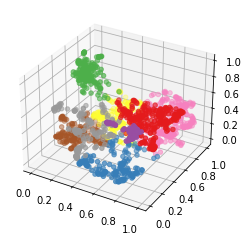

num clusters: 18


<Figure size 432x288 with 0 Axes>

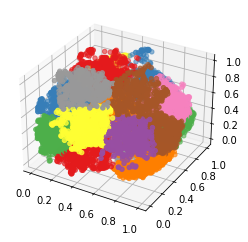

num clusters: 8


<Figure size 432x288 with 0 Axes>

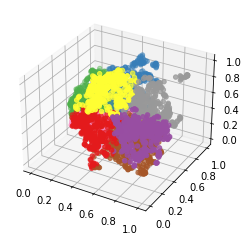

num clusters: 8


<Figure size 432x288 with 0 Axes>

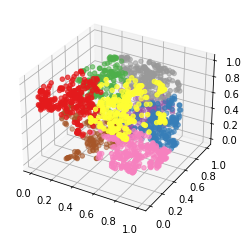

num clusters: 20


<Figure size 432x288 with 0 Axes>

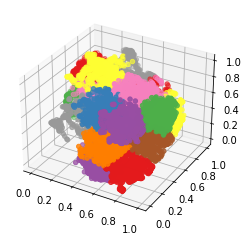

num clusters: 12


<Figure size 432x288 with 0 Axes>

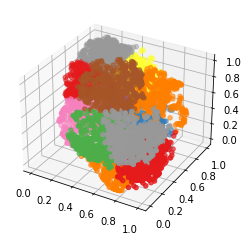

num clusters: 8


<Figure size 432x288 with 0 Axes>

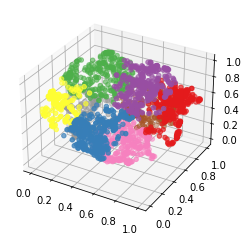

num clusters: 19


<Figure size 432x288 with 0 Axes>

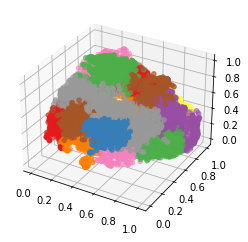

num clusters: 8


<Figure size 432x288 with 0 Axes>

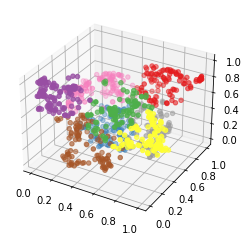

num clusters: 8


<Figure size 432x288 with 0 Axes>

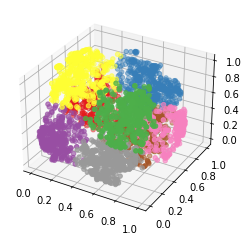

num clusters: 20


<Figure size 432x288 with 0 Axes>

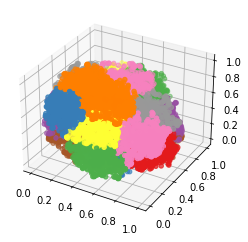

<Figure size 432x288 with 0 Axes>

In [152]:
reduce_by = 'umap'
base_folder = reduce_by + '_bytes'

for book_idx in range(0, len(book_text_data)):
  fig = plt.figure()
  ax = plt.axes(projection='3d')

  load_fname = '-'.join([str(book_idx), prefix, reduce_by, str(window)])
  with open(os.path.join(base_folder, load_fname), 'rb') as f:
    byte_arr = f.read()
    emb = np.frombuffer(byte_arr, dtype='float32').reshape((-1,3))

  arr_to_plot = emb
  sentences =  np.array(book_text_data[book_idx][split_by])

  # cluster w/ kmeans
  num_clusters = max(sentences.shape[0]/500, 8)
  num_clusters = np.round(num_clusters).astype(int)
  print("num clusters:", num_clusters)
  kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(emb)

  # Data for three-dimensional scattered points
  zdata = arr_to_plot[:, 2]
  xdata = arr_to_plot[:, 0]
  ydata = arr_to_plot[:, 1]
  ax.scatter3D(xdata, ydata, zdata, c=kmeans.labels_, cmap='Set1');

  plt.show()
  plt.savefig('plots/' + str(book_idx) + '-' + reduce_by)

In [153]:
book_text_data[2]['sentences'][0]

'Chapter I. PETER BREAKS THROUGH'

In [154]:
ls section_text_data

0-universal-pca-1-cutoff-cluster-data.json
0-universal-umap-1-cutoff-cluster-data.json
1-universal-pca-1-cutoff-cluster-data.json
1-universal-umap-1-cutoff-cluster-data.json
10-universal-pca-1-cutoff-cluster-data.json
10-universal-umap-1-cutoff-cluster-data.json
2-universal-pca-1-cutoff-cluster-data.json
2-universal-umap-1-cutoff-cluster-data.json
3-universal-pca-1-cutoff-cluster-data.json
3-universal-umap-1-cutoff-cluster-data.json
4-universal-pca-1-cutoff-cluster-data.json
4-universal-umap-1-cutoff-cluster-data.json
5-universal-pca-1-cutoff-cluster-data.json
5-universal-umap-1-cutoff-cluster-data.json
6-universal-pca-1-cutoff-cluster-data.json
6-universal-umap-1-cutoff-cluster-data.json
7-universal-pca-1-cutoff-cluster-data.json
7-universal-umap-1-cutoff-cluster-data.json
8-universal-pca-1-cutoff-cluster-data.json
8-universal-umap-1-cutoff-cluster-data.json
9-universal-pca-1-cutoff-cluster-data.json
9-universal-umap-1-cutoff-cluster-data.json


## Save Files

In [161]:
from google.colab import files

/Users/harinisuresh/.virtualenvs/book-viz/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [162]:
files.download('book_text_data.json')

KeyboardInterrupt: 

In [166]:
!zip -r section_text_data.zip section_text_data
files.download('section_text_data.zip')

  adding: section_text_data/ (stored 0%)
  adding: section_text_data/8-universal-pca-1-cutoff-cluster-data.json (deflated 79%)
  adding: section_text_data/1-universal-umap-1-cutoff-cluster-data.json (deflated 70%)
  adding: section_text_data/0-universal-umap-1-cutoff-cluster-data.json (deflated 74%)
  adding: section_text_data/6-universal-umap-1-cutoff-cluster-data.json (deflated 73%)
  adding: section_text_data/4-universal-pca-1-cutoff-cluster-data.json (deflated 77%)
  adding: section_text_data/0-universal-pca-1-cutoff-cluster-data.json (deflated 79%)
  adding: section_text_data/7-universal-umap-1-cutoff-cluster-data.json (deflated 70%)
  adding: section_text_data/7-universal-pca-1-cutoff-cluster-data.json (deflated 78%)
  adding: section_text_data/3-universal-pca-1-cutoff-cluster-data.json (deflated 80%)
  adding: section_text_data/9-universal-umap-1-cutoff-cluster-data.json (deflated 72%)
  adding: section_text_data/8-universal-umap-1-cutoff-cluster-data.json (deflated 74%)
  addin

KeyboardInterrupt: 

In [ ]:
save_bytes = True
if save_bytes: 
  !zip -r /content/umap_bytes.zip /content/umap_bytes
  !zip -r /content/tsne_bytes.zip /content/tsne_bytes
  !zip -r /content/pca_bytes.zip /content/pca_bytes
  files.download('umap_bytes.zip')
  files.download('tsne_bytes.zip')
  files.download('pca_bytes.zip')

In [165]:
ls

GenerateBookData.ipynb  plots/                  tsne_bytes/
book_text_data.json     raw_book_text/          umap_bytes/
pca_bytes/              section_text_data/


In [163]:
files

<module 'google.colab.files' from '/Users/harinisuresh/.virtualenvs/book-viz/lib/python3.7/site-packages/google/colab/files.py'>